In [48]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
path = '../CHL/'
infn = 'all_L3m_AV_CHL1_100km_global_monthly_merged_1997_2020_processed.nc'

ds_CHL = xr.open_dataset(path + infn)
# ds_CHL

# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(40, 100) # bounds inclusive

# Get data, selecting lat/lon slice
mon_chl = ds_CHL['mon_chl'].sel(lat=lat_slice,lon=lon_slice)
mon_chl_mon_anom = ds_CHL['mon_chl_mon_anom'].sel(lat=lat_slice,lon=lon_slice)
chl_mon_clim = ds_CHL['chl_mon_clim'].sel(lat=lat_slice,lon=lon_slice)
lat = mon_chl_mon_anom.lat.values
lon = mon_chl_mon_anom.lon.values

# Functions

In [49]:
def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
#         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

#         if  (~np.isnan(arr[row,col])) & cond):
        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        for j,(lo, la) in enumerate(rem_sta):
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break

            # then check diagonals
            elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind


def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# 1 degree

No Next Station Found. Returning Previous Stations Only.
(12, 36) [(58, 25), (58, 20), (18, 20), (17, 20), (16, 20), (15, 20), (14, 20), (13, 20), (12, 20)]


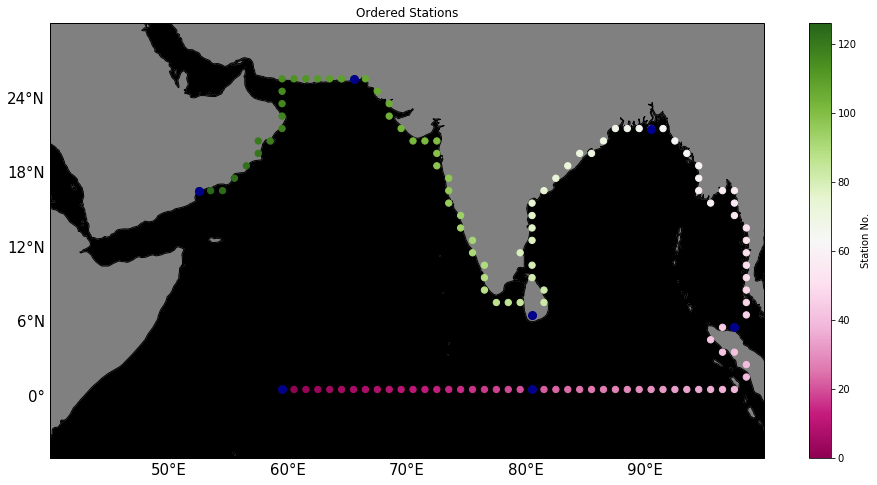

In [64]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = chl_mon_clim[0,:,:]
# xx,yy = np.meshgrid(lon,lat)

# set Gulfs to Nans
mask = mask.where(~((yy>22) & (xx<59)))
mask = mask.where(~((yy>10) & (xx<51)))

# AS inlets
mask = mask.where(~((yy>21) & (yy<23) & (xx>70) & (xx<73)))
mask = mask.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)))
mask = mask.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)))

# sri lanka are
mask = mask.where(~((yy>8) & (yy<11) & (xx>77) & (xx<80)))

#bob
mask = mask.where(~((yy>22) & (yy<23) & (xx>90) & (xx<95)))

# Sumatra area
mask = mask.where(~((yy>4.5) & (yy<5) & (xx>95.5) & (xx<100)))
mask = mask.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<100)))
mask = mask.where(~((xx>99) & (yy<12)& (yy>6)))

# equator
mask = mask.where(~(yy<0))
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))
# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

# AS
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~((lons_from_sta <52) & (lats_from_sta < 25))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = np.array(lon[sta_loninds_unord])
lats_from_sta = np.array(lat[sta_latinds_unord])

ind =  ~((lons_from_sta >99))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

# cmin = -0.2
# cmax = 0.2
# levels = np.linspace(cmin, cmax, 10)

# # Start figure
# fig = plt.figure(figsize=(16, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())
# add_land(ax,[40,105,-5,30])
# plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
#             s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
# plt.scatter(lon[sta_loninds_unord[16]],lat[sta_latinds_unord[16]],
#             s = 160,c='darkblue',marker = '.')
# plt.colorbar(label = 'Station No.')
# plt.title('Unordered Stations')

# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#

#initial station
sta_zero = (sta_loninds_unord[7],sta_latinds_unord[7]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#

EQ = 0
JA = 21
sBoB = 45
mBoB = 65
SL = 84
sAS = 90
mAS = 108
eAS = 126
loc_list = [EQ,JA,sBoB,mBoB,SL,mAS,eAS]
# 
# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,[40,100,-5,30])
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
# xx,yy = np.meshgrid(lon,lat)
# plt.scatter(xx.flatten(),yy.flatten(),s = 160,c='w',marker = '.')
p =plt.scatter(lon[sta_loninds],lat[sta_latinds],
            s = 160,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lon[sta_loninds[loc_list]],lat[sta_latinds[loc_list]],
            s = 260,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Ordered Stations')

plt.savefig('../../figures/stations-CHL-along-coast-1-degree.png', dpi=300, bbox_inches='tight')

In [65]:
no_stations =np.linspace(1,len(sta_loninds),len(sta_loninds))
# convert to xarray dataset
ds=xr.Dataset(coords={'no_stations': no_stations})

ds['sta_loninds'] = xr.DataArray(sta_loninds,dims = ['no_stations'],coords =[no_stations])
ds['sta_latinds'] = xr.DataArray(sta_latinds,dims = ['no_stations'],coords =[no_stations])
ds['loc_list'] = xr.DataArray(loc_list,dims = ['loc_list'],coords =[loc_list])
ds.to_netcdf('../../data/CHL/CHL-1-degree-coastlines.nc',mode='w',format = "NETCDF4")
ds

<xarray.Dataset>
Dimensions:      (loc_list: 7, no_stations: 127)
Coordinates:
  * no_stations  (no_stations) float64 1.0 2.0 3.0 4.0 ... 125.0 126.0 127.0
  * loc_list     (loc_list) int64 0 21 45 65 84 108 126
Data variables:
    sta_loninds  (no_stations) int64 19 20 21 22 23 24 25 ... 17 16 15 14 13 12
    sta_latinds  (no_stations) int64 20 20 20 20 20 20 20 ... 39 38 37 36 36 36

# 2 degree